# NOTE: 
09/01/23: 
1. I NEED TO CHECK WHAT THE TIME BOUNDS ARE ON NSIDC DATA - TIMEBOUNDS FOR CESM ARE 01/15 - 02/15. If this doesnt match NSIDC, then we have a problem and I need to modify. The time series looks like it's one-off! Same with Ed's why is that? 
2. Download recent extra NSIDC data
3. Clean up dotplot!
4. 

In [1]:
import os
import cmocean

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc

from glob import glob

# Local Utils
sys.path.insert(0, "/glade/work/zespinosa/Projects/climate-utils")
from utils import (
    plot_stationary_sp,
)

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


# Utils

In [2]:
def calc_sia_sie(area: xr.DataArray, siconc: xr.DataArray, hem: str = "NH", prod: str = "CESM"):
    """Calc SIE and SIA for CESM2 and NSIDC data.
    """
    if prod == "CESM":
        lat_mid_index = int(len(siconc.lat)/2)
        if hem == "NH":
            siconc = siconc[:, lat_mid_index:, :]
            area = area[lat_mid_index:, :]
        if hem == "SH":
            siconc = siconc[:, :lat_mid_index, :]
            area = area[:lat_mid_index, :]
        lat, lon = "nlat", "nlon"
        div = 1e12
    else:
        lat, lon = "latitude", "longitude"
        div = 1e6

    # Calculate sia and sie
    sia = ((siconc * area).sum([lat, lon]) / div).rename("sia")
    sie = (xr.where(siconc >= 0.15, area, 0).sum([lat, lon]) / div).rename("sie")
    
    return sia.to_dataset(), sie.to_dataset()

# Load

### CESM2

In [3]:
cesm2_areacello = xr.open_dataset("/glade/work/zespinosa/GRIDS/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc")

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#### PROCESS DATA

In [4]:
myvariables = ["aice"]
drop_vars = xr.open_dataset("/glade/scratch/zespinosa/archive/cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge/ice/hist/cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.cice.h.2019-05.nc").drop_vars(myvariables)
drop_vars = drop_vars.data_vars

# SSP370 Data
files_ssp370 = sorted(glob("/glade/scratch/zespinosa/archive/cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge/ice/hist/*.h.*.nc"))
files_hist = sorted(glob("/glade/scratch/zespinosa/archive/cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge/ice/hist/*.h.*.nc"))
cesm2_cice = xr.open_mfdataset(files_hist + files_ssp370, parallel=True, coords="minimal", drop_variables=drop_vars)
cesm2_cice["time"] = np.arange("1979-01-01", "2024-01-01", dtype="datetime64[M]")
cesm2_cice = cesm2_cice.rename({"TLON": "lon", "TLAT": "lat", "nj": "nlat", "ni": "nlon"})
# Saving cice
cesm2_cice.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_cice.monthly.197901-202312.nc")

#### OR LOAD DATA

In [31]:
cesm2_cice = xr.open_dataset("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_cice.monthly.197901-202312.nc")
cesm2_cice = cesm2_cice.rename({"TLON": "lon", "TLAT": "lat", "nj": "nlat", "ni": "nlon"})

### CESM1 

In [5]:
cesm1_cice = xr.open_dataset("/glade/work/zespinosa/Projects/Antarctica_2022/cesm_nudged/ens_01.nc") 
cesm1_cice = cesm1_cice.rename({"TLON": "lon", "TLAT": "lat", "nj": "nlat", "ni": "nlon"})
cesm1_cice["aice"] = cesm1_cice["aice"]/100

In [6]:
cesm1_areacello = xr.open_dataset("/glade/work/zespinosa/GRIDS/areacello_fx_CESM1-CAM5_historical_r0i0p0.nc")
cesm1_areacello = cesm1_areacello.rename({"i": "nlon", "j": "nlat"})

### NSIDC

In [10]:
nsidc_cice = xr.open_dataset("/glade/work/zespinosa/data/nsidc/daily/south/raw/seaice_conc_monthly_197901-202308.nc")
nsidc_cice = nsidc_cice.rename({"cdr_seaice_conc": "aice", "y": "latitude", "x": "longitude"})

In [8]:
nsidc_areacello = xr.open_dataset("/glade/work/zespinosa/GRIDS/areacello_Bootstrap_polar_stereo_25km_SH.nc")
nsidc_areacello = nsidc_areacello.rename({"ygrid": "latitude", "xgrid": "longitude"})

# Anomalies

## Calculate

In [11]:
nsidc_cice = nsidc_cice.bounds.add_bounds("T")
nsidc_cice_anoms = nsidc_cice.temporal.departures("aice", "month")
nsidc_cice_anoms.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_cice_anoms.monthly.197901-202312.nc")

In [12]:
cesm2_cice = cesm2_cice.bounds.add_bounds("T")
cesm2_cice_anoms = cesm2_cice.temporal.departures("aice", "month")
cesm2_cice_anoms.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_cice_anoms.monthly.197901-202312.nc")

2023-09-01 16:39:39,902 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-09-01 16:39:39,911 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 45 times more chunks
  return self.array[key]
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages

In [13]:
cesm1_cice = cesm1_cice.bounds.add_bounds("T")
cesm1_cice_anoms = cesm1_cice.temporal.departures("aice", "month")
cesm1_cice_anoms.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_cice_anoms.monthly.197901-202312.nc")

## Load

In [ ]:
nsidc_cice_anoms = xr.open_dataset("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_cice.monthly.197901-202312.nc")
cesm2_cice_anoms = xr.open_dataset("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_cice.monthly.197901-202312.nc")
cesm1_cice_anoms = xr.open_dataset("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_cice.monthly.197901-202312.nc")

# Sea ice Area and Extent

## Calculate

In [ ]:
REF_PERIOD = ("1990-01-01", "2010-01-01")

In [15]:
sia_nsidc, sie_nsidc = calc_sia_sie(nsidc_areacello.areacello, nsidc_cice.aice, hem="SH", prod="NSIDC") 
sia_nsidc.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sia.monthly.197901-202312.nc")
sie_nsidc.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sie.monthly.197901-202312.nc")

sie_nsidc = sie_nsidc.bounds.add_bounds("T")
sie_anoms_nsidc = sie_nsidc.temporal.departures("sie", freq="month", reference_period=REF_PERIOD)
sie_anoms_nsidc.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sie_anoms.monthly.197901-202312.nc")

sia_nsidc = sia_nsidc.bounds.add_bounds("T")
sia_anoms_nsidc = sia_nsidc.temporal.departures("sia", freq="month", reference_period=REF_PERIOD)
sia_anoms_nsidc.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sia_anoms.monthly.197901-202312.nc")

In [18]:
cesm2_cice = cesm2_cice.rename({"TLON": "lon", "TLAT": "lat", "nj": "nlat", "ni": "nlon"})
sia_cesm2, sie_cesm2 = calc_sia_sie(cesm2_areacello.areacello, cesm2_cice.aice, hem="SH")
sia_cesm2.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sia.monthly.197901-202312.nc")
sie_cesm2.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sie.monthly.197901-202312.nc")

sie_cesm2 = sie_cesm2.bounds.add_bounds("T")
sie_anoms_cesm2 = sie_cesm2.temporal.departures("sie", freq="month", reference_period=REF_PERIOD)
sie_anoms_cesm2.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sie_anoms.monthly.197901-202312.nc")

sia_cesm2 = sia_cesm2.bounds.add_bounds("T")
sia_anoms_cesm2 = sia_cesm2.temporal.departures("sia", freq="month", reference_period=REF_PERIOD)
sia_anoms_cesm2.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sia_anoms.monthly.197901-202312.nc")

2023-09-01 16:49:21,992 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-09-01 16:49:21,996 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 45 times more chunks
  return self.array[key]
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages

In [ ]:
sia_cesm1, sie_cesm1 = calc_sia_sie(cesm1_areacello.areacello, cesm1_cice.aice, hem="SH")
sia_cesm1.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sia.monthly.197901-202312.nc")
sie_cesm1.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sie.monthly.197901-202312.nc")

sie_cesm1 = sie_cesm1.bounds.add_bounds("T")
sie_anoms_cesm1 = sie_cesm1.temporal.departures("sie", freq="month", reference_period=REF_PERIOD)
sie_anoms_cesm1.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sie_anoms.monthly.197901-202312.nc")

sia_cesm1 = sia_cesm1.bounds.add_bounds("T")
sia_anoms_cesm1 = sia_cesm1.temporal.departures("sia", freq="month", reference_period=REF_PERIOD)
sia_anoms_cesm1.to_netcdf("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sia_anoms.monthly.197901-202312.nc")

## Load

In [ ]:
sia_anoms_cesm2 = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sia_anoms.monthly.197901-202312.nc")
sia_anoms_cesm2 = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm2_sia_anoms.monthly.197901-202312.nc")

sia_anoms_cesm1 = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sia_anoms.monthly.197901-202312.nc")
sia_anoms_cesm1 = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/cesm1_sia_anoms.monthly.197901-202312.nc")

sia_anoms_nsidc = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sia_anoms.monthly.197901-202312.nc")
sia_anoms_nsidc = xr.open_dataarray("/glade/scratch/zespinosa/data/CESM2/NUDGED/nsidc_sia_anoms.monthly.197901-202312.nc")

# Analysis

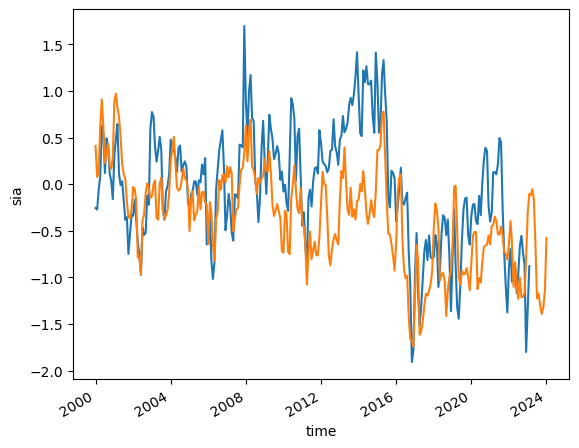

In [126]:
# sie_anoms_nsidc["sie"].sel(time=slice("2000-01-01", "2024-01-01")).plot()
# sie_anoms["sie"].sel(time=slice("2000-01-01", "2024-01-01")).plot()
(sia_anoms_nsidc["sia"].sel(time=slice("2000-01-01", "2024-01-01"))).plot()
(sia_anoms["sia"].sel(time=slice("2000-01-01", "2024-01-01"))/100).plot()

# Plotting

In [55]:
def spatial_cesm_plot(dt: xr.DataArray, anoms: bool = False, title: str = "", sp: str = ""):
    if anoms: 
        vmin, vmax = -1, 1
        cmap = cmocean.cm.balance_r
    else: 
        vmin, vmax = 0, 1
        cmap = cmocean.cm.ice

    fig, ax = plot_stationary_sp()
    dt = dt[:367,:]
    # Plot siconc filled contours
    img = ax.pcolormesh(
        cesm2_areacello.lon[:367,:],
        cesm2_areacello.lat[:367,:],
        dt,
        transform=ccrs.PlateCarree(), 
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
    fig.set_size_inches(8, 8)


/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


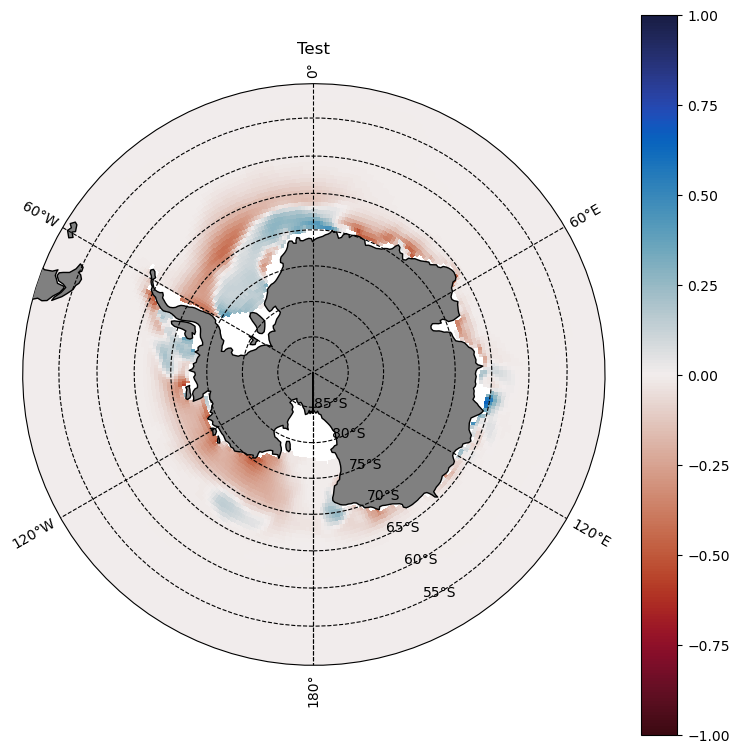

In [60]:
spatial_cesm_plot(cice_anoms.aice.isel(time=-24), anoms=True, title="Test")

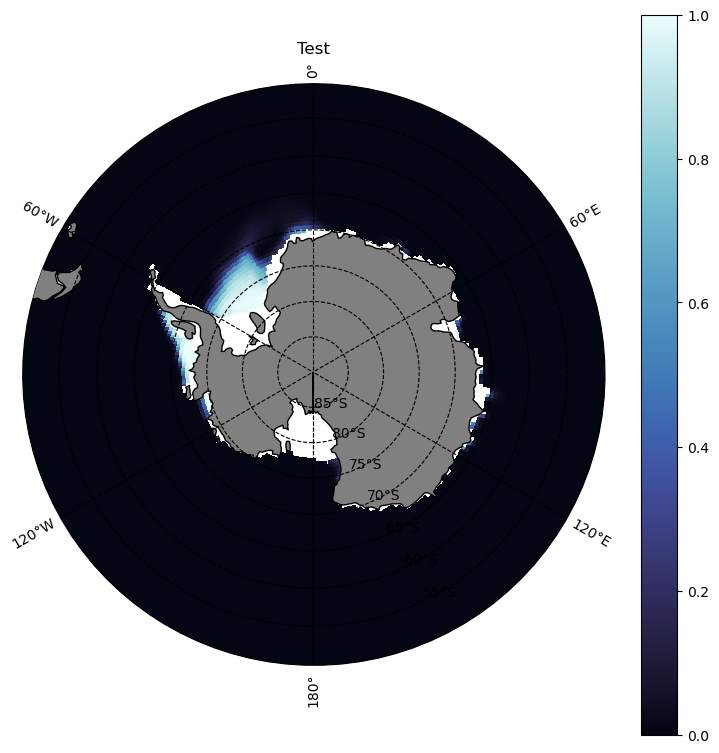

In [62]:
spatial_cesm_plot(cice.aice.isel(time=-22), anoms=False, title="Test")